In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel('dataset.xlsx')

In [3]:
df = data.copy()

In [4]:
df.shape

(5644, 111)

## Création des sous-ensembles (suite au EDA)

In [5]:
missing_rate = df.isna().sum()/df.shape[0]

In [6]:
blood_columns = list(df.columns[(missing_rate < 0.9) & (missing_rate >0.88)])
viral_columns = list(df.columns[(missing_rate < 0.80) & (missing_rate > 0.75)])

In [7]:
key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [8]:
df = df[key_columns + blood_columns + viral_columns]
df.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected


In [9]:
## TrainTest - Nettoyage - Encodage

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [12]:
def encodage(df):
    code = {'negative':0,
            'positive':1,
            'not_detected':0,
            'detected':1}
    
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)
        
    return df

In [13]:
def feature_engineering(df):
    df['est malade'] = df[viral_columns].sum(axis=1) >= 1
    df = df.drop(viral_columns, axis=1)
    return df

In [14]:
def imputation(df):#elimination des variables manquant
    #df['is na'] = (df['Parainfluenza 3'].isna()) | (df['Leukocytes'].isna()) missing indicator
    #df = df.fillna(-999)
    df = df.dropna(axis=0)
    return  df

In [15]:
def preprocessing(df):
    
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)
    
    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df['SARS-Cov-2 exam result']
    
    print(y.value_counts())
    
    return X, y

In [16]:
X_train, y_train = preprocessing(trainset)

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64


/home/bob/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-13-61e0718b463d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['est malade'] = df[viral_columns].sum(axis=1) >= 1


In [17]:
X_test, y_test = preprocessing(testset)

/home/bob/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64


<ipython-input-13-61e0718b463d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['est malade'] = df[viral_columns].sum(axis=1) >= 1


## Modelisation

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [19]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))##model de pypline
#SelectKBest(selecteur)qui utilise un test statistique , pour faire sa selection ,entre nos target et X_train
# par ex:test anova (f_classif) 
#k = nombre de features a selectionné,10 meilleur variable qui a de lien plus fort en test de 
# anova entre notre target et les variables (X_train)
#PolynomialFeatures(2),elevé au carré les variable , et de multiplier chaque varible avec ses voisines

In [20]:
model_x = SVC() #pas de feature_importance

In [21]:
model = DecisionTreeClassifier(random_state=0) #avec de feature importance(un peut de difficulté de resoudre l'overfiting)

In [22]:
model_rf = RandomForestClassifier(random_state = 0)

# Ptit recap

In [23]:
#model_x.fit(X_train,y_train)
#print(model_x.score(X_test,y_test))
#ypred_x = model.predict(X_test)
#print(confusion_matrix(y_test, ypred_x))
#print(classification_report(y_test, ypred_x))

In [24]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
#'svc__gamma': 0.001, 'svc__C': 1000, 'pipeline__selectkbest__k': 49, 'pipeline__polynomialfeatures__degree': 3

SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0  ))
SVM_perf = make_pipeline(PolynomialFeatures(3, include_bias=False), SelectKBest(f_classif, k=49), StandardScaler(), SVC(random_state=0,gamma = 0.001 ,C = 1000  ))

KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [25]:
KNN

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

## Procédure d'évaluation

In [26]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve #model en overfitting ou underfitting

In [34]:
def evaluation(model,name):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    print(y_test)
    print(ypred)
    
    print(confusion_matrix(y_test, ypred))
    print("y_test type = ",type(y_test),"lengh = ",y_test.shape)
    print("ypred type = " , type(ypred),"lengh = ",ypred.shape)
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    #N nombre d'echantillon
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.title(name)

895     0
4762    0
3378    0
3904    0
5511    0
       ..
95      0
552     0
5223    1
1281    0
4410    0
Name: SARS-Cov-2 exam result, Length: 111, dtype: int64
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[92  3]
 [10  6]]
y_test type =  <class 'pandas.core.series.Series'> lengh =  (111,)
ypred type =  <class 'numpy.ndarray'> lengh =  (111,)
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      0.67      0.71       111
weighted avg       0.87      0.88      0.87       111



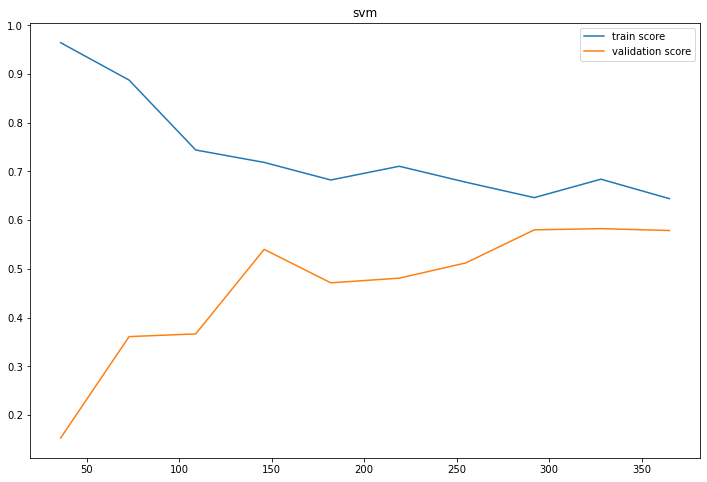

In [35]:
evaluation(SVM,'svm')

In [29]:
pd.DataFrame(model_rf.feature_importances_,index=X_train.columns) #variable le plus important

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
pd.DataFrame(model_rf.feature_importances_,index=X_train.columns).plot.bar(figsize=(12,8)) #variable le plus important

In [ ]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

In [ ]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model,name)

## OPTIMISATION

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
SVM

In [ ]:
SVM.steps

In [ ]:
hyper_params = {'svc__gamma':[1e-3, 1e-4],#, 0.0005
                'svc__C':[1, 10, 100, 1000], #, 3000
               'pipeline__polynomialfeatures__degree':[2, 3],
               'pipeline__selectkbest__k': range(40, 60)}

In [ ]:
hyper_params

In [ ]:
grid = RandomizedSearchCV(SVM, hyper_params, scoring='recall', cv=4,
                          n_iter=40) #nombre d'iteration (combinaison)
#recall ,minimisé les faut negatifs de s'enlessé de se baladé dans la nature
#optimisation de recall
grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)
#vecteur prediction
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
evaluation(grid.best_estimator_,"SVM")

In [ ]:
evaluation(SVM_perf,"SVM")

In [ ]:
SVM_perf.fit(X_train,y_train)
SVM_perf.score(X_train,y_train)

In [ ]:
ypred = SVM_perf.predict(X_test)
print(confusion_matrix(y_test, ypred))

## Poussé au mieux le model

In [ ]:
# utilisation de RandomizedSearchCV (beaucoup d'hyper parametre avec pipline preprocessor) dajà fais en haut

## Precision Recall Curve

In [ ]:
#pour visualisé la fiture sensibilité ou presision en fonction de seuil de probabilité
#Courbe precision(Recall)et on definissons un seuil (decision dangery/seuil de prediction)
#Threshold(seuil) si P(X) >= seuil,alors y = 1 ,P(X) <= seuil,alors y = 0

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))

In [ ]:
#grid.best_estimator_

In [ ]:
#precision[:-1]

In [ ]:
#threshold

In [ ]:
plt.plot(threshold, precision[:-1], label='precision(faux neg)')
plt.plot(threshold, recall[:-1], label='recall(faux pos)')
plt.legend()
#recall = 100% negatives mais positives(faux negatives)
#precision = gens ne sont pas infecté et va egalement les envoyé a l'hopitale(faux positives)
#c-a-d = gens testé negatives mais vraiment positives

In [ ]:
def model_final(model, X, threshold):
    return model.decision_function(X) > threshold

In [ ]:
y_pred = model_final(SVM_perf, X_test, threshold= -12)#grid.best_estimator_

In [ ]:
from sklearn.metrics import recall_score ,precision_score

In [ ]:
f1_score(y_test, y_pred)#0.53

In [ ]:
recall_score(y_test, y_pred)#0.75

In [ ]:
precision_score(y_test, y_pred)#0.48

In [ ]:
confusion_matrix(y_test, ypred)